In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata
import datetime
import numpy as np
import matplotlib.dates as mdates

In [7]:
# Get all raw data
nyt_data = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us.csv")
client = Socrata("healthdata.gov", None)
results = client.get("g62h-syeh", limit=200000)
test_results = client.get("j8mb-icvb", limit=200000)

In [8]:
# Filter data to get columns of interest
hhs_data = pd.DataFrame.from_records(results)[['state', 'date', 'inpatient_beds_used_covid']]
hhs_data = hhs_data.astype({'inpatient_beds_used_covid': 'float32'})
test_data = pd.DataFrame.from_records(test_results)[['state', 'date', 'overall_outcome', 'new_results_reported']]
test_data = test_data.astype({'new_results_reported': 'float32'})

In [9]:
hhs_data['date'] = hhs_data['date'].apply(lambda x: x[:10])
hhs_data['date'] = pd.to_datetime(hhs_data['date'])
test_data['date'] = test_data['date'].apply(lambda x: x[:10])
test_data['date'] = pd.to_datetime(test_data['date'])
nyt_data.date = pd.to_datetime(nyt_data.date)

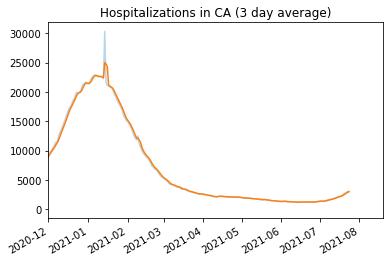

In [10]:
ca_data = hhs_data[hhs_data['state'] == 'CA']
ca_data = ca_data.sort_values(by='date', axis=0)
fig, ax = plt.subplots()
ax.plot(ca_data['date'], ca_data['inpatient_beds_used_covid'], alpha=.3)
ax.plot(ca_data['date'], ca_data.inpatient_beds_used_covid.rolling(3).mean()) #--- How to calculate rolling average, not needed for hospitalizations
plt.title("Hospitalizations in CA (3 day average)")
plt.xlim(left=datetime.date(2020, 12, 1))
fig.autofmt_xdate()
plt.show()


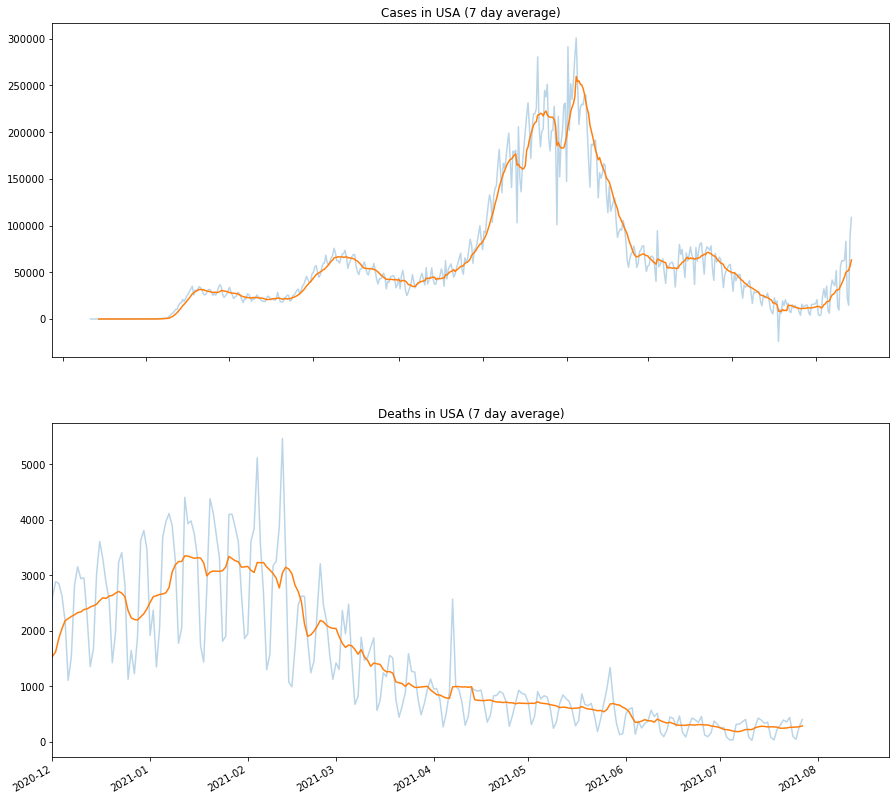

In [11]:
nyt_data_usa = nyt_data[nyt_data.geoid=="USA"]
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,15))
ax1.plot(nyt_data_usa['date'], nyt_data_usa['cases'], alpha=.3)
ax1.plot(nyt_data_usa['date'], nyt_data_usa.cases.rolling(7).mean())
ax2.plot(nyt_data_usa['date'], nyt_data_usa['deaths'], alpha=.3)
ax2.plot(nyt_data_usa.date, nyt_data_usa.deaths.rolling(7).mean())

ax1.title.set_text("Cases in USA (7 day average)")
ax2.title.set_text("Deaths in USA (7 day average)")
plt.xlim(left=datetime.date(2020, 12, 1))
fig.autofmt_xdate()

In [70]:
"""
TODO: Add function signature, add start_date and end_date params

"""
def get_state_positivity(state_code, start_date, end_date):
    test_data_state = test_data[test_data.state == state_code] # Get only data from input State
    max_date = test_data.date.max()
    curr_date = start_date
    lst = []
    while(curr_date < end_date and curr_date < max_date): # Loop through all unique dates
        day_data = test_data_state[test_data_state.date == str(curr_date)]
        test_pos = day_data[day_data.overall_outcome == "Positive"].new_results_reported # Get num positive tests
        test_pos = test_pos.item() if test_pos.any() else 0 # Extract number if exists
        test_neg = day_data[day_data.overall_outcome == "Negative"].new_results_reported # Get num negative tests
        test_neg = test_neg.item() if test_neg.any() else 0 # Extract number if exists
        if(test_pos == 0 and test_neg == 0):
            test_pct = 0 # Fixes divide by zero issue
        else:
            test_pct = test_pos/ (test_pos + test_neg) * 100
        newRow = {"state": state_code, "date": curr_date, "test_positivity": test_pct}
        lst.append(newRow)
        curr_date += datetime.timedelta(1)

    return pd.DataFrame(lst) # Create dataframe with all dates and test positivity

In [98]:
"""
plot_state_positivity
Creates plot of state positivity over time
state (str): State to query
returns: nothing
"""
def plot_state_positivity(state):
    state_tests = test_positivity_of_state(state)
    fig, ax = plt.subplots()
    ax.plot(state_tests.date, state_tests.test_positivity, alpha=.3)
    ax.plot(state_tests.date, state_tests.test_positivity.rolling(7).mean()) #--- How to calculate rolling average, not needed for hospitalizations
    plt.title(f"Test Positivity in {state} (3 day average)")
    # plt.xlim(left=datetime.date(2020, 12, 1))
    fig.autofmt_xdate()
    plt.show()

"""
get_us_positivity
Constructs a data table of the entire US test positivity

start_date (datetime.date) : Starting date of table
end_date (datetime.date) : Ending date of table
returns: dataframe with date, test positivity

"""
def get_us_positivity(start_date, end_date):
    curr_date = start_date
    max_date = test_data.date.max()
    lst = []
    while (curr_date < end_date and curr_date < max_date):
        test_data_curr = test_data[test_data.date==str(curr_date)]
        test_pos = test_data_curr[test_data_curr.overall_outcome == "Positive"]
        test_neg = test_data_curr[test_data_curr.overall_outcome == "Negative"]
        pos_sum = test_pos.new_results_reported.sum()
        neg_sum = test_neg.new_results_reported.sum()
        test_positivity = pos_sum / (pos_sum + neg_sum) * 100
        newRow = {"date": curr_date, "test_positivity": test_positivity}
        lst.append(newRow)
        curr_date += datetime.timedelta(1)
    return pd.DataFrame(lst)

"""
plot_positivity
Plots test positivity graph with 7 day average

data: dataframe time series with columns 'date' and 'test_positivity'
location: string of location name for labeling
"""
def plot_positivity(data, location, plot_color):
    fig, ax = plt.subplots()
    x, y0, y1 = data.date, data.test_positivity, data.test_positivity.rolling(7).mean()
    ax.plot(x, y0, alpha=.3)
    ax.plot(x, y1, color=plot_color)
    plt.title(f"Test Positivity in {location} (7 day average)")
    plt.fill_between(x, y1, 0, facecolor=plot_color, color=plot_color, alpha=0.2)
    fig.autofmt_xdate()
    plt.show()




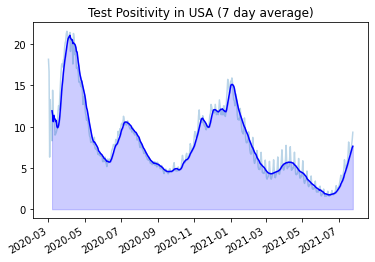

In [102]:
starting_date = datetime.date(2020,3,1)
end_date = datetime.date.today()
us_pos = get_us_positivity(starting_date, end_date)
plot_positivity(us_pos, "USA", 'blue')

TODO:

-Add 4 part plot
-Make it so all 4 visualizations can be initialized with one function call